In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
from mat6115.hidden import run_and_save_hidden, get_hidden
from mat6115.dataset import dataset_factory, TEXT, LABEL, SEED
from mat6115.model import RNN
from mat6115.train import custom_loss, acc
from poutyne.framework import Model
import torch
from torch import nn
from pathlib import Path
import json
import pickle

plt.style.use('ggplot')
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True


In [3]:
train_iter, valid_iter, test_iter = dataset_factory("imdb", embedding="glove.6B.100d")

In [15]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

SAVE_PATH = Path('lstm_2layer/')
with open(SAVE_PATH / "kwargs.json", 'r') as kwargs_file:
    kwargs = json.load(kwargs_file)

num_layers = kwargs["n_layers"]

vanilla_network=RNN(**kwargs)
trained_network=RNN(**kwargs)

vanilla = Model(
    network=vanilla_network, 
    optimizer=torch.optim.Adam(vanilla_network.parameters()), 
    loss_function=custom_loss,
    batch_metrics=[acc]
)
trained = Model(
    network=trained_network, 
    optimizer=torch.optim.Adam(trained_network.parameters()), 
    loss_function=custom_loss,
    batch_metrics=[acc]
)
trained.load_weights(SAVE_PATH / 'model.pkl')

vanilla.to(device)
trained.to(device)

/home/alexis/miniconda3/envs/mat6115/lib/python3.8/site-packages/torch/nn/modules/rnn.py:47: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [16]:
import spacy
nlp = spacy.load('en')

def predict_sentiment(model, sentence):
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]
    length = [len(indexed)]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(0)
    length_tensor = torch.LongTensor(length)
    prediction = model.predict((tensor, length_tensor), batch_size=1)
    return 1 * LABEL.vocab.stoi['neg'] - 1 / (1 + np.exp(-prediction[0]))

In [17]:
predict_sentiment(trained, "This film is terrible")

array([0.06689703], dtype=float32)

In [18]:
predict_sentiment(vanilla, "This film is terrible")

array([0.5004122], dtype=float32)

In [19]:
vanilla_hidden_states, vanilla_preds, vanilla_ground_truth = get_hidden(
    vanilla, test_iter, N=5000
)

In [20]:

trained_hidden_states, trained_preds, trained_ground_truth = get_hidden(
    trained, test_iter, N=5000
)

In [22]:
pca_vanilla = [PCA() for _ in range(num_layers)]
pca_trained = [PCA() for _ in range(num_layers)]

for i in range(num_layers):
    pca_vanilla[i].fit(vanilla_hidden_states[i])
    pca_trained[i].fit(trained_hidden_states[i])
    
with open(SAVE_PATH / 'pca_trained.pkl', 'wb') as pca_trained_file:
    pickle.dump(pca_trained, pca_trained_file)
    
with open(SAVE_PATH / 'pca_vanilla.pkl', 'wb') as pca_vanilla_file:
    pickle.dump(pca_vanilla, pca_vanilla_file)

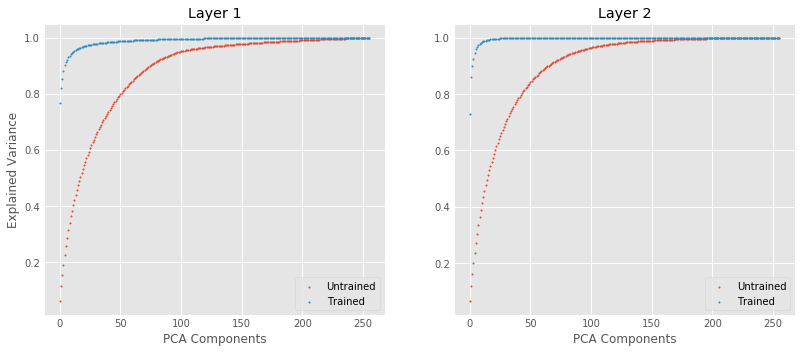

In [35]:
fig, ax = plt.subplots(
    1, num_layers, 
    figsize=(6 * num_layers, 5)
)

ax[0].set_ylabel('Explained Variance')
for i in range(num_layers):
    ax[i].scatter(
        np.arange(len(pca_vanilla[i].explained_variance_ratio_)),
        pca_vanilla[i].explained_variance_ratio_.cumsum(),
        s=2,
#         c="#aaaaaa"
    )
    ax[i].scatter(
        np.arange(len(pca_trained[i].explained_variance_ratio_)),
        pca_trained[i].explained_variance_ratio_.cumsum(),
        s=2,
#         c="#282828"
    )
    ax[i].set_xlabel('PCA Components')
    ax[i].legend(['Untrained', 'Trained'])
    ax[i].set_title(f'Layer {i+1}')

In [24]:
pca_vanilla_2 = [PCA(n_components=2) for _ in range(num_layers)]
pca_trained_2 = [PCA(n_components=2) for _ in range(num_layers)]


vanilla = np.empty((num_layers, vanilla_hidden_states.shape[1], 2))
trained = np.empty((num_layers, trained_hidden_states.shape[1], 2))
for i in range(vanilla_hidden_states.shape[0]):
    vanilla[i] = pca_vanilla_2[i].fit_transform(vanilla_hidden_states[i])
    trained[i] = pca_trained_2[i].fit_transform(trained_hidden_states[i])
    
with open(SAVE_PATH / 'pca_trained_2.pkl', 'wb') as pca_trained_file:
    pickle.dump(pca_trained_2, pca_trained_file)
    
with open(SAVE_PATH / 'pca_vanilla_2.pkl', 'wb') as pca_vanilla_file:
    pickle.dump(pca_vanilla_2, pca_vanilla_file)

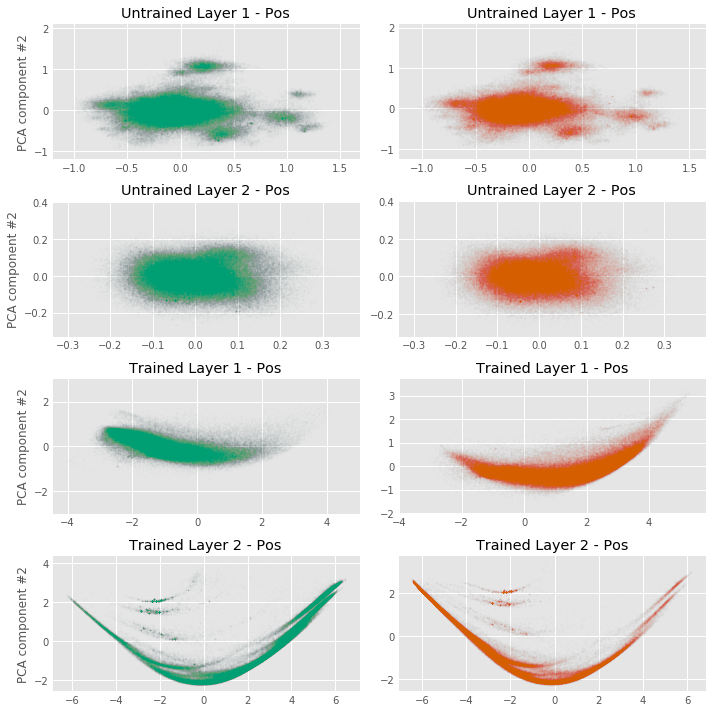

In [37]:
fig, ax = plt.subplots(2 * num_layers, 2, figsize=(10, 10))
pos_idx = vanilla_ground_truth == LABEL.vocab.stoi['pos']
neg_idx = vanilla_ground_truth == LABEL.vocab.stoi['neg']
GREEN = "#009E73"
RED = "#D55E00"

ax[0][0].scatter(vanilla[0, pos_idx, 0], vanilla[0, pos_idx, 1], c=GREEN, alpha=0.009, s=2)
ax[0][0].set_title('Untrained Layer 1 - Pos')
ax[0][0].set_ylabel("PCA component #2")

ax[0][1].scatter(vanilla[0, neg_idx, 0], vanilla[0, neg_idx, 1], c=RED, alpha=0.009, s=2)
ax[0][1].set_title('Untrained Layer 1 - Pos')

ax[1][0].scatter(vanilla[1, pos_idx, 0], vanilla[1, pos_idx, 1], c=GREEN, alpha=0.009, s=2)
ax[1][0].set_title('Untrained Layer 2 - Pos')
ax[1][0].set_ylabel("PCA component #2")

ax[1][1].scatter(vanilla[1, neg_idx, 0], vanilla[1, neg_idx, 1], c=RED, alpha=0.009, s=2)
ax[1][1].set_title('Untrained Layer 2 - Pos')

ax[2][0].scatter(trained[0, pos_idx, 0], trained[0, pos_idx, 1], c=GREEN, alpha=0.009, s=2)
ax[2][0].set_title('Trained Layer 1 - Pos')
ax[2][0].set_ylabel("PCA component #2")

ax[2][1].scatter(trained[0, neg_idx, 0], trained[0, neg_idx, 1], c=RED, alpha=0.009, s=2)
ax[2][1].set_title('Trained Layer 1 - Pos')

ax[3][0].scatter(trained[1, pos_idx, 0], trained[1, pos_idx, 1], c=GREEN, alpha=0.009, s=2)
ax[3][0].set_title('Trained Layer 2 - Pos')
ax[3][0].set_ylabel("PCA component #2")

ax[3][1].scatter(trained[1, neg_idx, 0], trained[1, neg_idx, 1], c=RED, alpha=0.009, s=2)
ax[3][1].set_title('Trained Layer 2 - Pos')

plt.tight_layout()

In [67]:

pca_trained_3 = PCA(n_components=3)

trained_data_3 = pca_trained_3.fit_transform(trained_hidden_states)

<IPython.core.display.Javascript object>


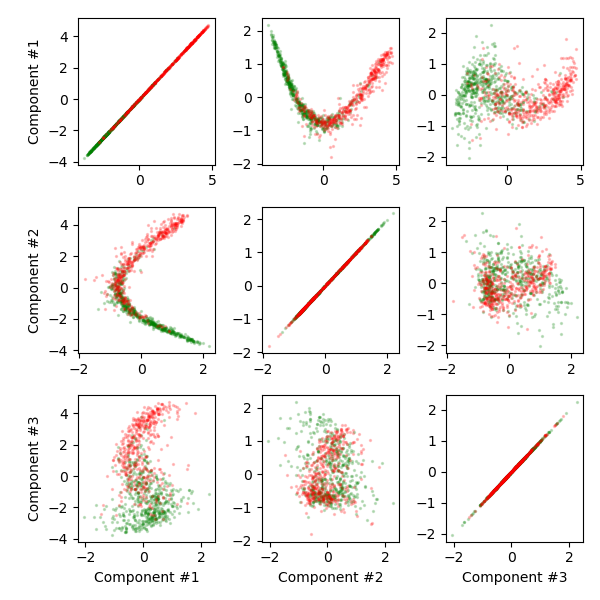

(3, 3)


In [72]:
from itertools import product

fig, ax = plt.subplots(3, 3, figsize=(6, 6))
random_idx = np.arange(len(trained_data_3))
np.random.shuffle(random_idx)
random_idx = random_idx[:1000]

pos_idx = vanilla_ground_truth[random_idx] == LABEL.vocab.stoi['pos']
neg_idx = vanilla_ground_truth[random_idx] == LABEL.vocab.stoi['neg']
print(ax.shape)

for i, j in product([0,1,2], [0,1,2]):
    ax[i][j].scatter(
        trained_data_3[random_idx][pos_idx, i], 
        trained_data_3[random_idx][pos_idx, j], 
        c='g', alpha=0.2, s=2
    )
    ax[i][j].scatter(
        trained_data_3[random_idx][neg_idx, i], 
        trained_data_3[random_idx][neg_idx, j], 
        c='r', alpha=0.2, s=2
    )
    if j == 0:
        ax[i][j].set_ylabel(f"Component #{i+1}")
    if i == 2:
        ax[i][j].set_xlabel(f"Component #{j+1}")



plt.tight_layout()

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib notebook

In [74]:

pca_trained_3 = PCA(n_components=3)

trained_data_3 = pca_trained_3.fit_transform(trained_hidden_states)

<IPython.core.display.Javascript object>


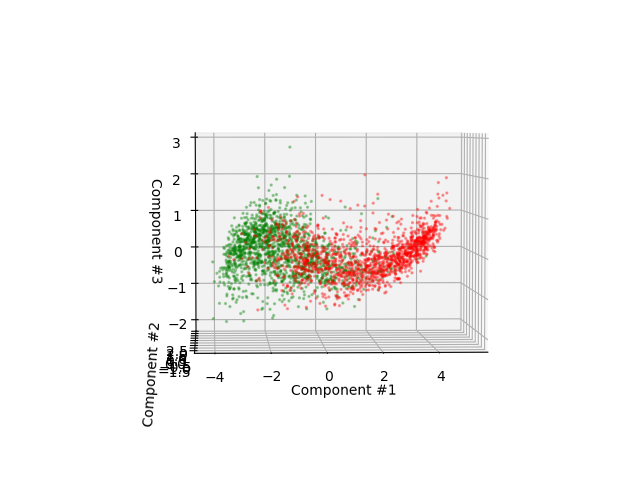

Text(0.5, 0, 'Component #3')

In [75]:
# Plot trajectory
fig = plt.figure()
ax = plt.axes(projection='3d')
random_idx = np.arange(len(trained_data_3))
np.random.shuffle(random_idx)
random_idx = random_idx[:3000]

pos_idx = trained_ground_truth[random_idx] == LABEL.vocab.stoi['pos']
neg_idx = trained_ground_truth[random_idx] == LABEL.vocab.stoi['neg']

ax.scatter3D(
    trained_data_3[random_idx][pos_idx,0],
    trained_data_3[random_idx][pos_idx,1],
    trained_data_3[random_idx][pos_idx,2],
    c='g', s=2, alpha=0.3
)

ax.scatter3D(
    trained_data_3[random_idx][neg_idx,0],
    trained_data_3[random_idx][neg_idx,1],
    trained_data_3[random_idx][neg_idx,2],
    c='r', s=2, alpha=0.3
)

ax.set_xlabel('Component #1')
ax.set_ylabel('Component #2')
ax.set_zlabel('Component #3')

In [53]:
trained_data_3[random_idx][pos_idx,2].shape

(496,)